In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"



In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import cv2

### Loading and preparing data

In [3]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [4]:
# create train and test arrays
X_train = []
X_test = []
y_train = []
y_test = []
predict = []

# Reshape images to image_size
image_size = 224

# Create training data
for i in labels:
    folder_path = os.path.join('Dataset','Training',i)
    for j in (os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

# create testing data
for i in labels:
    folder_path = os.path.join('Dataset','Testing',i)
    for j in (os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path,j))
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
        y_test.append(i)
       
# Create predict data
folder_path = os.path.join('Dataset','Predict')
for j in (os.listdir(folder_path)):
    img = cv2.imread(os.path.join(folder_path,j))
    img = cv2.resize(img,(image_size, image_size))
    predict.append(img)
    
    
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
predict = np.array(predict)

In [5]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('Predict shape:', predict.shape)

X_train shape: (5712, 224, 224, 3)
X_test shape: (1271, 224, 224, 3)
Predict shape: (40, 224, 224, 3)


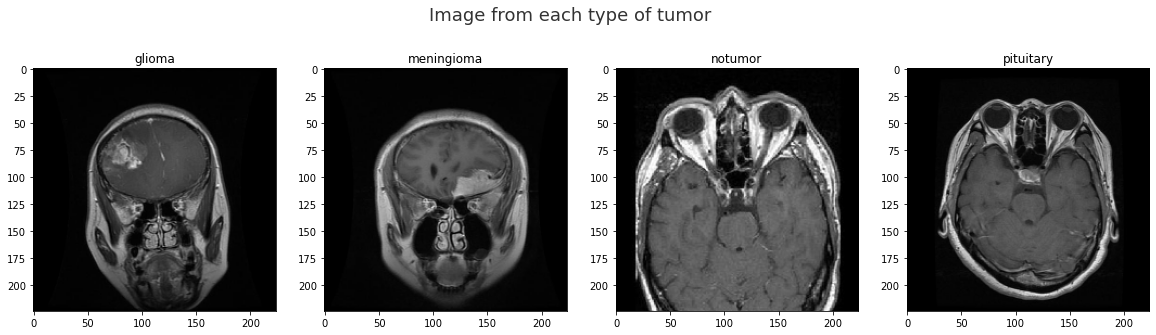

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Image from each type of tumor', size=18, y=0.62, x=0.4, alpha=0.8)
 
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j], cmap='gray')
            ax[k].set_title(y_train[j])
            k+=1
            break
        j+=1

### Encode y_test, y_train to one hot encoding using to_categorical function

In [7]:
from tensorflow.keras.utils import to_categorical

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = to_categorical(y_train, 4)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = to_categorical(y_test, 4)

In [9]:
print(y_test[0])
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

[1. 0. 0. 0.]
y_train shape: (5712, 4)
y_test shape: (1271, 4)


# Test diffrent models

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


from tensorflow.keras.optimizers import Adam
import keras
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0, VGG16, ResNet50
from sklearn.metrics import classification_report,confusion_matrix

### Gridsearch efficientNet
GridSearchCV not used to tune paramteres here, since the only layer where we can change hyperparameter is Dropout rate.
It is used to be able to cross validate and compare it to the other models.  

In [22]:
def effnet(rate):
    effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
    model = effnet.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=rate)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=effnet.input, outputs = model)
    model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
    return model

In [23]:
effnet_clf = KerasClassifier(build_fn = effnet)

In [24]:
params1 = {
    'rate': [0.5]
}

In [14]:
grid_search1 = GridSearchCV(estimator=effnet_clf, param_grid=params1, cv=5)

In [15]:
# Start gridsearchCV
grid_search1 = grid_search1.fit(X_train, y_train, epochs = 15)

Epoch 1/15
143/143 [==============================] - 45s 254ms/step - loss: 0.2557 - accuracy: 0.9122
Epoch 2/15
143/143 [==============================] - 35s 248ms/step - loss: 0.0969 - accuracy: 0.9680
Epoch 3/15
143/143 [==============================] - 35s 243ms/step - loss: 0.0704 - accuracy: 0.9768
Epoch 4/15
143/143 [==============================] - 34s 240ms/step - loss: 0.0439 - accuracy: 0.9851
Epoch 5/15
143/143 [==============================] - 34s 238ms/step - loss: 0.0278 - accuracy: 0.9932
Epoch 6/15
143/143 [==============================] - 34s 236ms/step - loss: 0.0347 - accuracy: 0.9897
Epoch 7/15
143/143 [==============================] - 34s 241ms/step - loss: 0.0213 - accuracy: 0.9921
Epoch 8/15
143/143 [==============================] - 38s 267ms/step - loss: 0.0310 - accuracy: 0.9906
Epoch 9/15
143/143 [==============================] - 34s 237ms/step - loss: 0.0303 - accuracy: 0.9904
Epoch 10/15
143/143 [==============================] - 33s 230ms/step - l

In [16]:
# Get the best parameters and accuracy from the grid search
#best_params_effnet = grid_search1.best_params_
accuracy_effnet = grid_search1.best_score_

In [1]:
# This shows error as the kernel had to be reset before going to the next gridsearch. Python garbage collectors are not able to remove garbage data from tensorflow so a lot of ram is still in use after running a gridsearch.
print('Best parameters:', best_params_effnet)
print('Best accuracy:', accuracy_effnet)

In [26]:
clf_eff = effnet(0.5)

In [27]:
clf_eff.summary()

Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_48[0][0]                   
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________________________________________________________________________

### GridSearch VGG16

In [28]:
def vgg(n_nodes):
    vgg = VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False, pooling='max')
    vgg.trainable = False
    model = tf.keras.layers.Flatten()(vgg.output)
    model = tf.keras.layers.Dense(n_nodes, activation='relu')(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=vgg.input, outputs = model)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [29]:
vgg_clf = KerasClassifier(build_fn = vgg)

In [30]:
# set parameters for gridsearchCV
params2 = {
    'n_nodes': [128, 256, 512]
}

In [14]:
grid_search2 = GridSearchCV(estimator=vgg_clf, param_grid=params2, cv=5)

In [15]:
# Start gridsearchCV
grid_search2 = grid_search2.fit(X_train, y_train, epochs = 15)

Epoch 1/15
143/143 [==============================] - 21s 98ms/step - loss: 4.2640 - accuracy: 0.6568
Epoch 2/15
143/143 [==============================] - 11s 80ms/step - loss: 0.7563 - accuracy: 0.7398
Epoch 3/15
143/143 [==============================] - 11s 74ms/step - loss: 0.6609 - accuracy: 0.7540
Epoch 4/15
143/143 [==============================] - 11s 74ms/step - loss: 0.5663 - accuracy: 0.7838
Epoch 5/15
143/143 [==============================] - 11s 75ms/step - loss: 0.5268 - accuracy: 0.8083
Epoch 6/15
143/143 [==============================] - 11s 74ms/step - loss: 0.4830 - accuracy: 0.8203
Epoch 7/15
143/143 [==============================] - 11s 74ms/step - loss: 0.4437 - accuracy: 0.8332
Epoch 8/15
143/143 [==============================] - 11s 74ms/step - loss: 0.4346 - accuracy: 0.8383
Epoch 9/15
143/143 [==============================] - 11s 74ms/step - loss: 0.4167 - accuracy: 0.8411
Epoch 10/15
143/143 [==============================] - 11s 74ms/step - loss: 0.386

143/143 [==============================] - 11s 76ms/step - loss: 5.5950 - accuracy: 0.7511
Epoch 2/15
143/143 [==============================] - 11s 75ms/step - loss: 0.7147 - accuracy: 0.8238
Epoch 3/15
143/143 [==============================] - 11s 75ms/step - loss: 0.4472 - accuracy: 0.8566
Epoch 4/15
143/143 [==============================] - 11s 76ms/step - loss: 0.3766 - accuracy: 0.8678
Epoch 5/15
143/143 [==============================] - 11s 75ms/step - loss: 0.3476 - accuracy: 0.8822
Epoch 6/15
143/143 [==============================] - 11s 75ms/step - loss: 0.3008 - accuracy: 0.8917
Epoch 7/15
143/143 [==============================] - 11s 75ms/step - loss: 0.2960 - accuracy: 0.8954
Epoch 8/15
143/143 [==============================] - 12s 81ms/step - loss: 0.2712 - accuracy: 0.9044
Epoch 9/15
143/143 [==============================] - 13s 87ms/step - loss: 0.2318 - accuracy: 0.9173
Epoch 10/15
143/143 [==============================] - 11s 79ms/step - loss: 0.2295 - accurac

In [17]:
# Get the best parameters and accuracy from the grid search
best_params_vgg = grid_search2.best_params_
accuracy_vgg = grid_search2.best_score_

In [18]:
print('Best parameters:', best_params_vgg)
print('Best accuracy:', accuracy_vgg)

Best parameters: {'n_nodes': 512}
Best accuracy: 0.6541430115699768


In [32]:
clf_vgg = vgg(512)

In [33]:
# display model summary
clf_vgg.summary()

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

### Gridsearch on ResNet50

In [11]:
def resnet(n_nodes1, n_nodes2):
    resnet = ResNet50(input_shape = (image_size, image_size, 3), weights ='imagenet', include_top = False, pooling ='max')
    model = tf.keras.layers.Flatten()(resnet.output)
    model = tf.keras.layers.Dense(n_nodes1, activation = 'relu')(model)
    model = tf.keras.layers.Dense(n_nodes2, activation = 'relu')(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4, activation = 'softmax')(model)
    model = tf.keras.models.Model(inputs = resnet.input, outputs = model)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
resnet_clf = KerasClassifier(build_fn = resnet)

In [13]:
# set parameters for gridsearchCV
params3 = {
    'n_nodes1': [128, 256, 512],
    'n_nodes2': [128, 256, 512],
}

In [14]:
grid_search3 = GridSearchCV(estimator=resnet_clf, param_grid=params3, cv=5)

In [15]:
# Start gridsearchCV
grid_search3 = grid_search3.fit(X_train, y_train, epochs = 15)

Epoch 1/15
143/143 [==============================] - 40s 225ms/step - loss: 1.5571 - accuracy: 0.7518
Epoch 2/15
143/143 [==============================] - 33s 234ms/step - loss: 0.5339 - accuracy: 0.8573
Epoch 3/15
143/143 [==============================] - 32s 225ms/step - loss: 0.3531 - accuracy: 0.8862
Epoch 4/15
143/143 [==============================] - 31s 217ms/step - loss: 0.3175 - accuracy: 0.8993
Epoch 5/15
143/143 [==============================] - 32s 225ms/step - loss: 0.3476 - accuracy: 0.8812
Epoch 6/15
143/143 [==============================] - 31s 218ms/step - loss: 0.2146 - accuracy: 0.9293
Epoch 7/15
143/143 [==============================] - 31s 219ms/step - loss: 0.1994 - accuracy: 0.9269
Epoch 8/15
143/143 [==============================] - 31s 217ms/step - loss: 0.1912 - accuracy: 0.9389
Epoch 9/15
143/143 [==============================] - 31s 218ms/step - loss: 0.1464 - accuracy: 0.9558
Epoch 10/15
143/143 [==============================] - 31s 217ms/step - l

143/143 [==============================] - 31s 215ms/step - loss: 0.0469 - accuracy: 0.9860s - loss: 0.0469 - accuracy: 0.98
Epoch 15/15
36/36 [==============================] - 3s 61ms/step - loss: 7.3490 - accuracy: 0.0088 1s - loss: - ETA: 0s - los
Epoch 1/15
143/143 [==============================] - 34s 216ms/step - loss: 0.7569 - accuracy: 0.7991
Epoch 2/15
143/143 [==============================] - 31s 217ms/step - loss: 0.3869 - accuracy: 0.8825
Epoch 3/15
143/143 [==============================] - 31s 217ms/step - loss: 0.4027 - accuracy: 0.8827
Epoch 4/15
143/143 [==============================] - 31s 217ms/step - loss: 0.2759 - accuracy: 0.9103
Epoch 5/15
143/143 [==============================] - 31s 216ms/step - loss: 0.2943 - accuracy: 0.9142
Epoch 6/15
143/143 [==============================] - 31s 217ms/step - loss: 0.1551 - accuracy: 0.9438
Epoch 7/15
143/143 [==============================] - 31s 216ms/step - loss: 0.2062 - accuracy: 0.9497
Epoch 8/15
143/143 [=======

143/143 [==============================] - 30s 213ms/step - loss: 0.1429 - accuracy: 0.9589
Epoch 11/15
143/143 [==============================] - 30s 213ms/step - loss: 0.1185 - accuracy: 0.9683
Epoch 12/15
143/143 [==============================] - 30s 213ms/step - loss: 0.1034 - accuracy: 0.9746
Epoch 13/15
143/143 [==============================] - 30s 213ms/step - loss: 0.2024 - accuracy: 0.9512s - loss: 0.2024 - accuracy: 0.95
Epoch 14/15
143/143 [==============================] - 30s 213ms/step - loss: 0.0962 - accuracy: 0.9729
Epoch 15/15
36/36 [==============================] - 3s 59ms/step - loss: 2134.9185 - accuracy: 0.0000e+00
Epoch 1/15
143/143 [==============================] - 34s 213ms/step - loss: 1.3648 - accuracy: 0.7634s - l
Epoch 2/15
143/143 [==============================] - 30s 213ms/step - loss: 0.5750 - accuracy: 0.8321
Epoch 3/15
143/143 [==============================] - 30s 213ms/step - loss: 0.4390 - accuracy: 0.8591
Epoch 4/15
143/143 [==================

143/143 [==============================] - 30s 211ms/step - loss: 0.1167 - accuracy: 0.9619
Epoch 8/15
143/143 [==============================] - 30s 211ms/step - loss: 0.2012 - accuracy: 0.9527
Epoch 9/15
143/143 [==============================] - 30s 211ms/step - loss: 0.0850 - accuracy: 0.9764
Epoch 10/15
143/143 [==============================] - 30s 211ms/step - loss: 0.0806 - accuracy: 0.9781
Epoch 11/15
143/143 [==============================] - 30s 211ms/step - loss: 0.1039 - accuracy: 0.9731
Epoch 12/15
143/143 [==============================] - 30s 211ms/step - loss: 0.2849 - accuracy: 0.9212
Epoch 13/15
143/143 [==============================] - 30s 211ms/step - loss: 0.1904 - accuracy: 0.9464
Epoch 14/15
143/143 [==============================] - 30s 211ms/step - loss: 0.0589 - accuracy: 0.9816
Epoch 15/15
36/36 [==============================] - 3s 58ms/step - loss: 1.6589 - accuracy: 0.6033
Epoch 1/15
143/143 [==============================] - 34s 212ms/step - loss: 1.402

143/143 [==============================] - 31s 215ms/step - loss: 0.5133 - accuracy: 0.8284
Epoch 3/15
143/143 [==============================] - 31s 215ms/step - loss: 0.3570 - accuracy: 0.8792
Epoch 4/15
143/143 [==============================] - 31s 215ms/step - loss: 0.3916 - accuracy: 0.8882
Epoch 5/15
143/143 [==============================] - 31s 215ms/step - loss: 0.2734 - accuracy: 0.9195
Epoch 6/15
143/143 [==============================] - 31s 215ms/step - loss: 0.1483 - accuracy: 0.9512
Epoch 7/15
143/143 [==============================] - 31s 215ms/step - loss: 0.0996 - accuracy: 0.9656
Epoch 8/15
143/143 [==============================] - 31s 215ms/step - loss: 0.1108 - accuracy: 0.9641
Epoch 9/15
143/143 [==============================] - 31s 215ms/step - loss: 0.0966 - accuracy: 0.9751
Epoch 10/15
143/143 [==============================] - 31s 215ms/step - loss: 0.4932 - accuracy: 0.9123
Epoch 11/15
143/143 [==============================] - 31s 215ms/step - loss: 0.188

In [16]:
# Get the best parameters and accuracy from the grid search
best_params_resnet = grid_search3.best_params_
accuracy_resnet = grid_search3.best_score_

In [17]:
print('Best parameters:', best_params_resnet)
print('Best accuracy:', accuracy_resnet)

Best parameters: {'n_nodes1': 256, 'n_nodes2': 256}
Best accuracy: 0.679871529340744


In [20]:
clf_res = resnet(256,256)

In [21]:
# display model summary
clf_res.summary()

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_47[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# Build and train EfficientNet Model

In [11]:
def efficientNet():
    effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
    model = effnet.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=effnet.input, outputs = model)
    model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
    return model

In [12]:
clf = efficientNet()

In [13]:
hist = clf.fit(X_train, y_train, validation_split = 0.1, epochs = 50, verbose = 1)

Epoch 1/50
161/161 [==============================] - 49s 254ms/step - loss: 0.2710 - accuracy: 0.9060 - val_loss: 0.1823 - val_accuracy: 0.9476
Epoch 2/50
161/161 [==============================] - 38s 235ms/step - loss: 0.0845 - accuracy: 0.9714 - val_loss: 0.2770 - val_accuracy: 0.9196
Epoch 3/50
161/161 [==============================] - 40s 246ms/step - loss: 0.0766 - accuracy: 0.9753 - val_loss: 5.5399 - val_accuracy: 0.2448
Epoch 4/50
161/161 [==============================] - 39s 240ms/step - loss: 0.0611 - accuracy: 0.9805 - val_loss: 0.0362 - val_accuracy: 0.9878
Epoch 5/50
161/161 [==============================] - 38s 234ms/step - loss: 0.0372 - accuracy: 0.9862 - val_loss: 0.1674 - val_accuracy: 0.9510
Epoch 6/50
161/161 [==============================] - 38s 234ms/step - loss: 0.0253 - accuracy: 0.9918 - val_loss: 0.0726 - val_accuracy: 0.9755
Epoch 7/50
161/161 [==============================] - 39s 243ms/step - loss: 0.0425 - accuracy: 0.9864 - val_loss: 5.9189 - val_ac

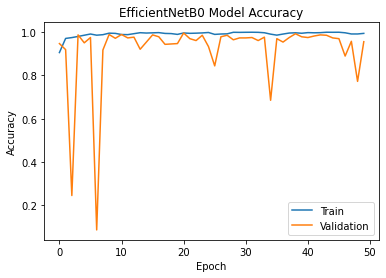

In [111]:
# plot model accuracy over epochs
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('EfficientNetB0 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

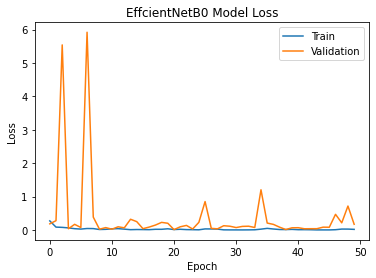

In [112]:
# Plot model loss over epochs
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('EffcientNetB0 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluate EfficientNetB0 model 

In [59]:
pred = clf.predict(X_test)

In [60]:
loss, accuracy = clf.evaluate(X_test, y_test)

40/40 [==============================] - 2s 45ms/step - loss: 0.0956 - accuracy: 0.9819


In [61]:
predictions = tf.argmax(pred, axis=1) # decode back to int from one-hot representation
print(predictions)

tf.Tensor([0 0 0 ... 1 3 3], shape=(1271,), dtype=int64)


In [62]:
true_class = tf.argmax(y_test, axis = 1) # decode back to int from one-hot representation
print(true_class)

tf.Tensor([0 0 0 ... 3 3 3], shape=(1271,), dtype=int64)


#### EfficientNet model confusion matrix and classification report

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
import seaborn as sns

In [64]:
cf_matrix = confusion_matrix(true_class, predictions)

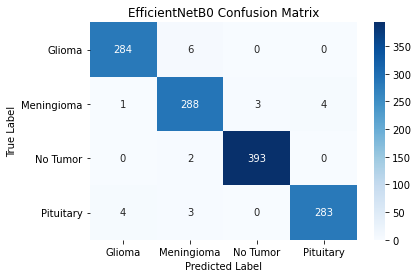

In [125]:

x_axis_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
y_axis_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

sns.heatmap(cf_matrix, annot=True,xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='', cmap='Blues')
plt.title('EfficientNetB0 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [126]:
#target_names = ['T-Shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(classification_report(true_class, predictions, target_names = labels))

              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       290
  meningioma       0.96      0.97      0.97       296
     notumor       0.99      0.99      0.99       395
   pituitary       0.99      0.98      0.98       290

    accuracy                           0.98      1271
   macro avg       0.98      0.98      0.98      1271
weighted avg       0.98      0.98      0.98      1271



### Visualize misclassified tumors by EfficientNet
Code for this visualization was found at https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist#Visualize-classified-images and is adapted for this model implementation. Original code written by GABRIEL PREDA.

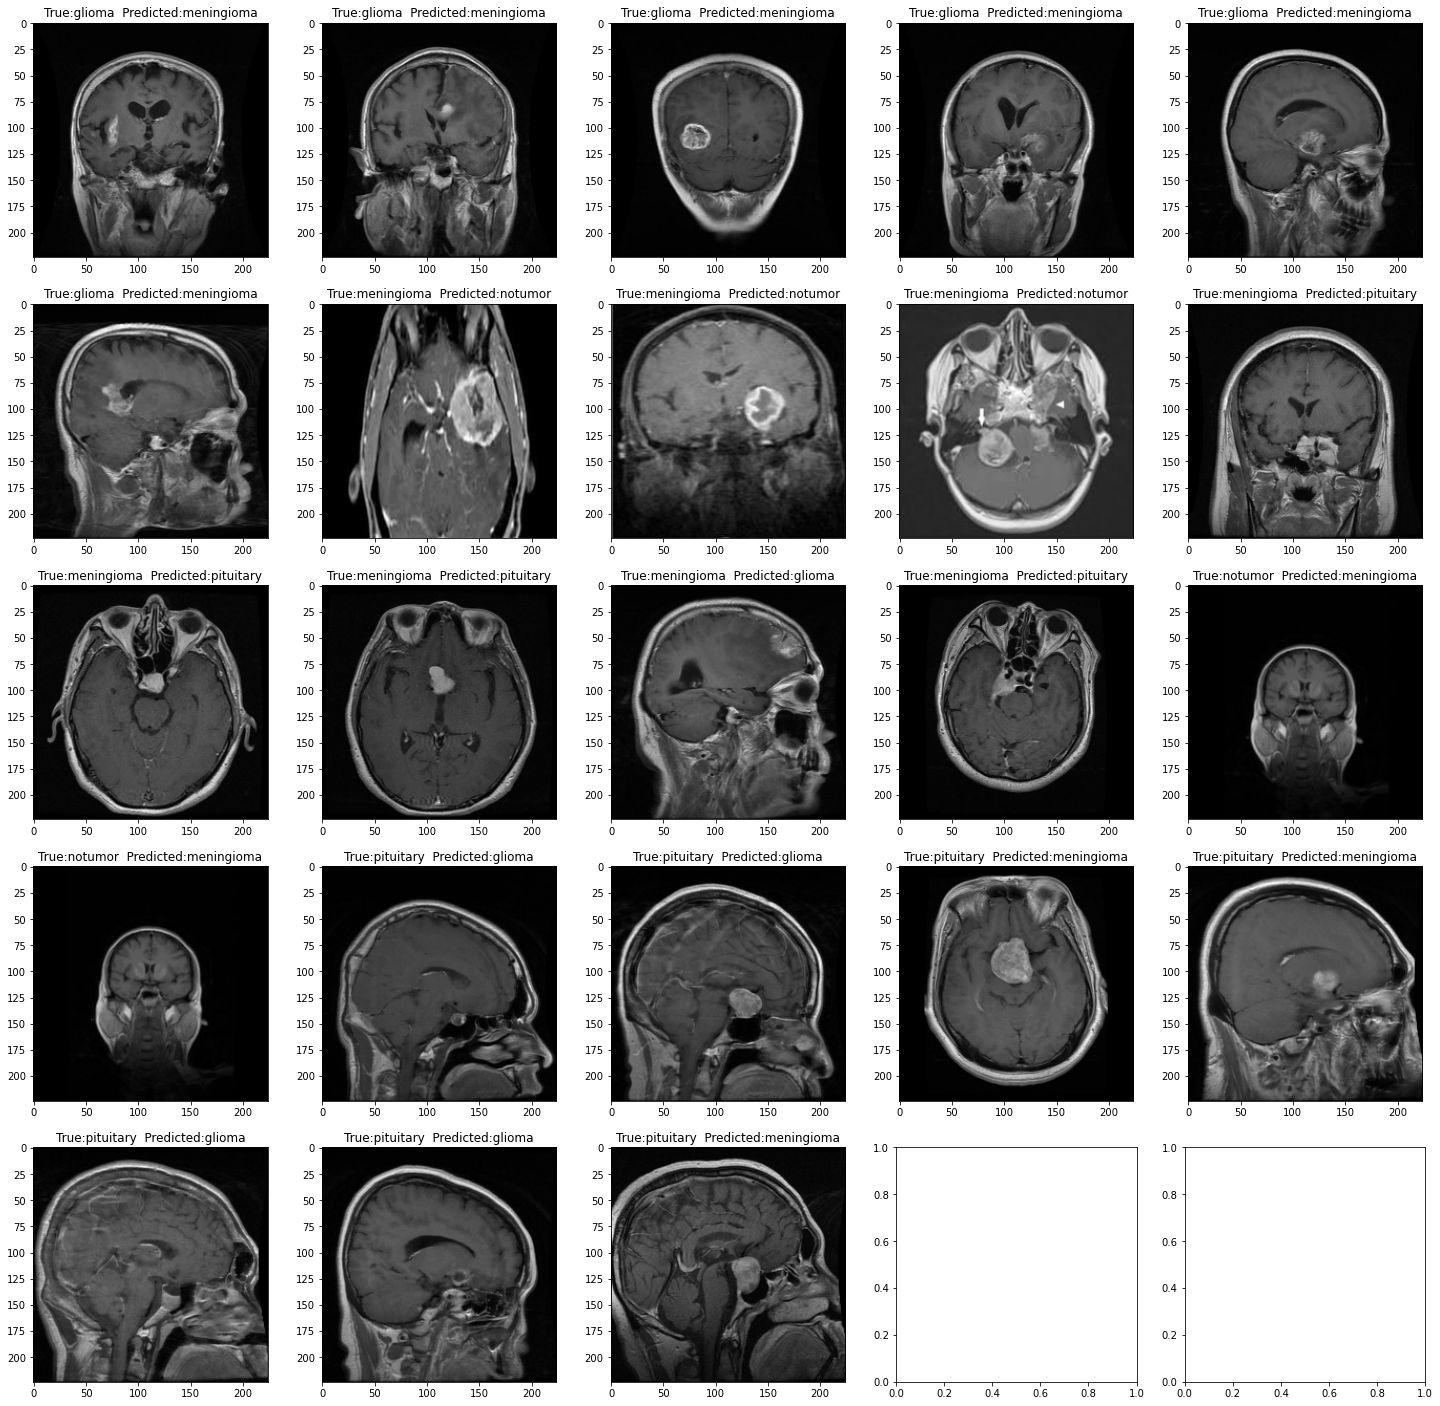

In [90]:
incorrect = np.nonzero(predictions!=true_class)[0]

def plot_images(data_index,cmap="Blues"):
    fig, ax = plt.subplots(5,5, figsize=(25,25))

    for i, index in enumerate(data_index[:25]):
        ax[i//5, i%5].imshow(X_test[index], cmap=cmap)
        ax[i//5, i%5].set_title("True:{}  Predicted:{}".format(labels[true_class[index]], labels[predictions[index]]))
    plt.show()    
    
plot_images(incorrect, 'gray')

In [122]:
# save model
clf.save('clf.h5')

C:\Users\marti\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Build and train VGG16 model. 

In [74]:
# function to build VGG model
def vgg():
    vgg = VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False, pooling='max')
    vgg.trainable = False
    model = tf.keras.layers.Flatten()(vgg.output)
    model = tf.keras.layers.Dense(512, activation='relu')(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=vgg.input, outputs = model)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [76]:
vgg_clf = vgg()

In [77]:
# Train vgg model
hist_vgg = vgg_clf.fit(X_train, y_train, validation_split = 0.1, epochs = 50, verbose = 1)

Epoch 1/50
161/161 [==============================] - 23s 120ms/step - loss: 5.8101 - accuracy: 0.7263 - val_loss: 0.7661 - val_accuracy: 0.7535
Epoch 2/50
161/161 [==============================] - 14s 89ms/step - loss: 0.6733 - accuracy: 0.7944 - val_loss: 0.5589 - val_accuracy: 0.8007
Epoch 3/50
161/161 [==============================] - 14s 85ms/step - loss: 0.4797 - accuracy: 0.8331 - val_loss: 0.3148 - val_accuracy: 0.8951
Epoch 4/50
161/161 [==============================] - 14s 87ms/step - loss: 0.4104 - accuracy: 0.8537 - val_loss: 0.2299 - val_accuracy: 0.9371
Epoch 5/50
161/161 [==============================] - 14s 85ms/step - loss: 0.3591 - accuracy: 0.8644 - val_loss: 0.2177 - val_accuracy: 0.9353
Epoch 6/50
161/161 [==============================] - 13s 82ms/step - loss: 0.3452 - accuracy: 0.8716 - val_loss: 0.3604 - val_accuracy: 0.8986
Epoch 7/50
161/161 [==============================] - 14s 86ms/step - loss: 0.3036 - accuracy: 0.8879 - val_loss: 0.2121 - val_accuracy

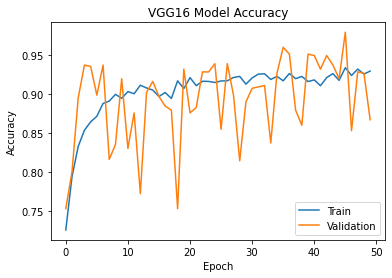

In [107]:
# plot model accuracy over epochs
plt.plot(hist_vgg.history['accuracy'])
plt.plot(hist_vgg.history['val_accuracy'])
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

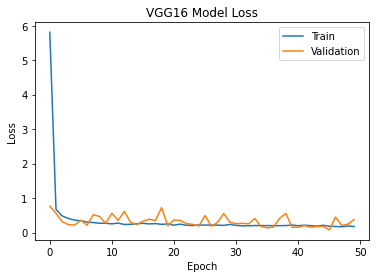

In [108]:
# Plot model loss over epochs
plt.plot(hist_vgg.history['loss'])
plt.plot(hist_vgg.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluate VGG16

In [82]:
pred_vgg16 = vgg_clf.predict(X_test)

In [83]:
loss, accuracy = vgg_clf.evaluate(X_test, y_test)

40/40 [==============================] - 3s 73ms/step - loss: 0.2430 - accuracy: 0.9182


In [84]:
predictions_vgg16 = tf.argmax(pred_vgg16, axis=1) # decode back to int from one-hot representation
print(predictions_vgg16)

tf.Tensor([0 0 0 ... 3 3 3], shape=(1271,), dtype=int64)


In [85]:
true_class = tf.argmax(y_test, axis = 1) # decode back to int from one-hot representation
print(true_class)

tf.Tensor([0 0 0 ... 3 3 3], shape=(1271,), dtype=int64)


#### VGG16 model confusion matrix and classification report

In [86]:
cf_matrix_vgg = confusion_matrix(true_class, predictions_vgg16)

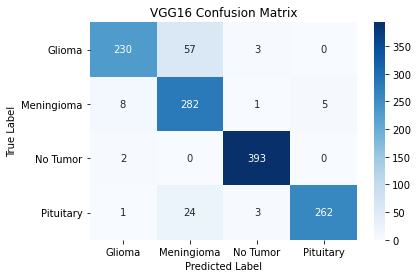

In [114]:
x_axis_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
y_axis_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

sns.heatmap(cf_matrix_vgg, annot=True,xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='', cmap='Blues')
plt.title('VGG16 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [89]:
print(classification_report(true_class, predictions_vgg16, target_names = labels))

              precision    recall  f1-score   support

      glioma       0.95      0.79      0.87       290
  meningioma       0.78      0.95      0.86       296
     notumor       0.98      0.99      0.99       395
   pituitary       0.98      0.90      0.94       290

    accuracy                           0.92      1271
   macro avg       0.92      0.91      0.91      1271
weighted avg       0.93      0.92      0.92      1271



### Visualize misclassified tumors by VGG16

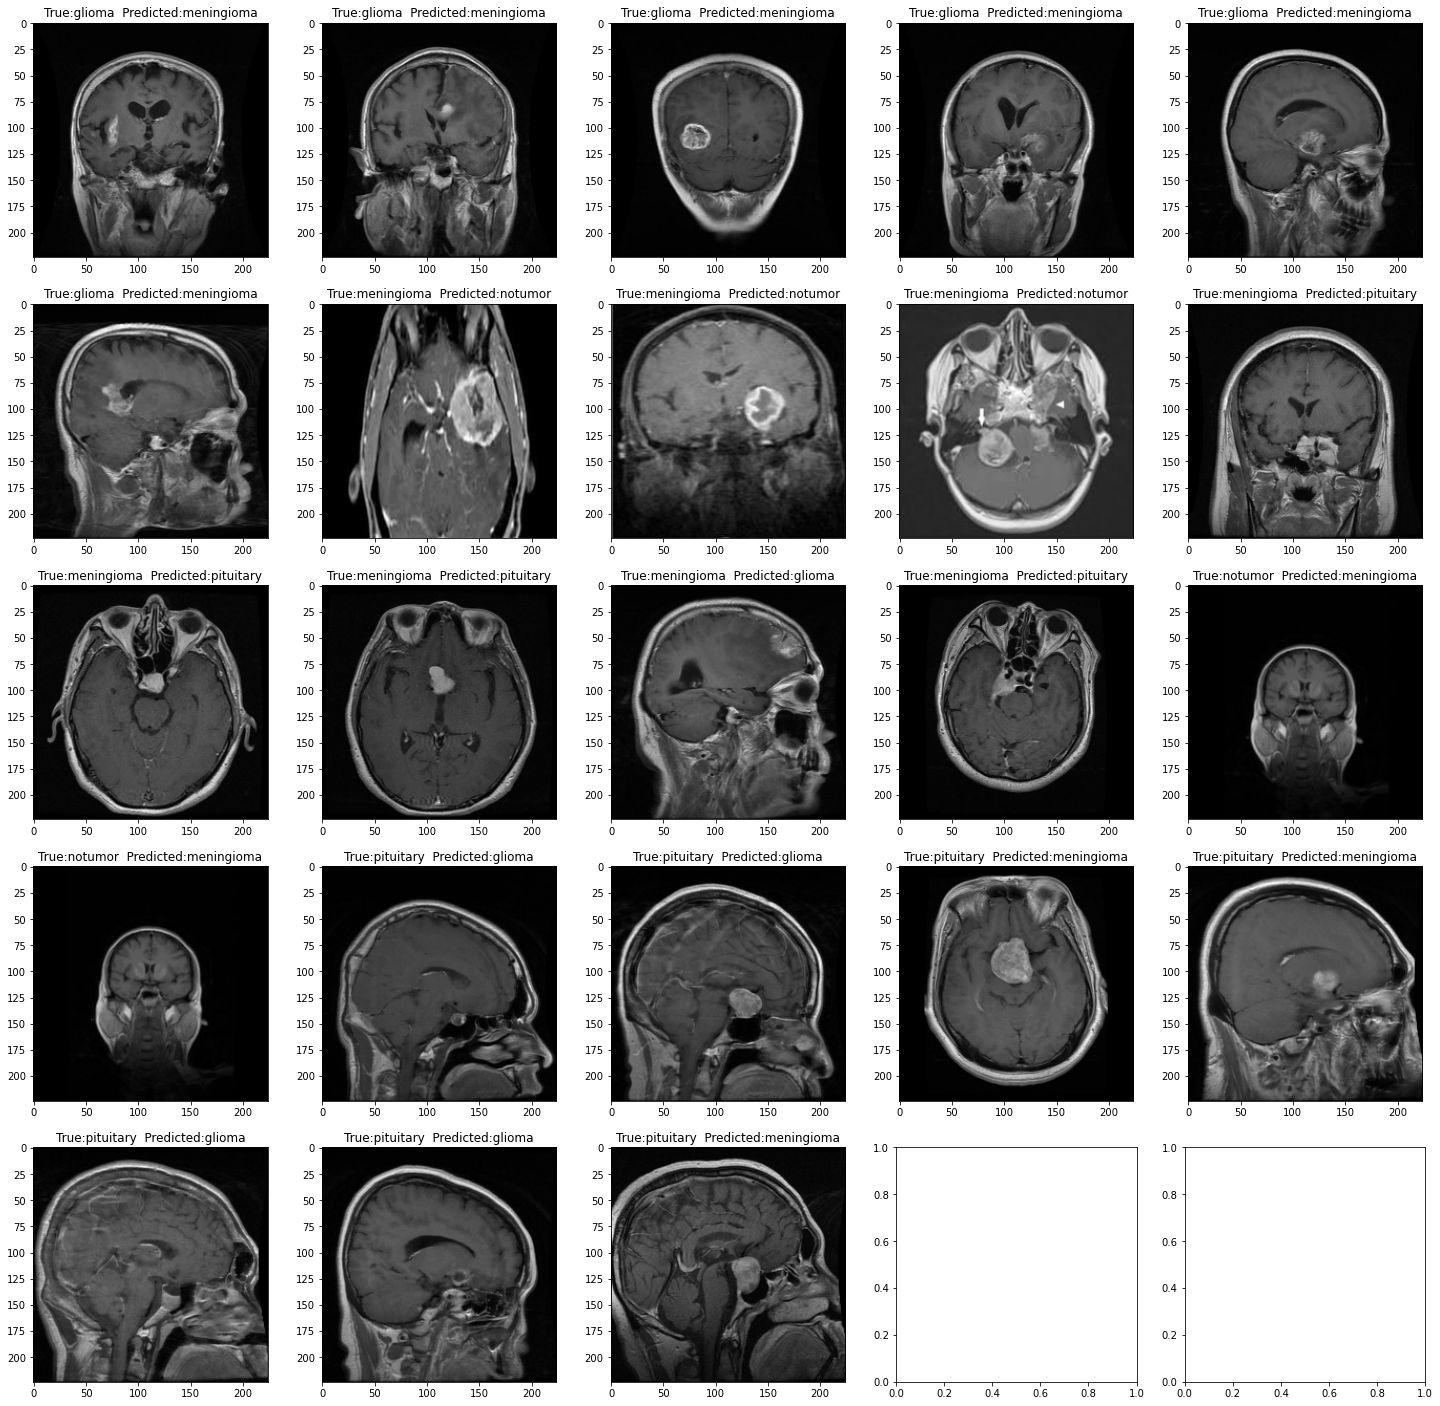

In [91]:

incorrect_vgg = np.nonzero(predictions_vgg16!=true_class)[0]

def plot_images(data_index,cmap="Blues"):
    fig, ax = plt.subplots(5,5, figsize=(25,25))

    for i, index in enumerate(data_index[:25]):
        ax[i//5, i%5].imshow(X_test[index], cmap=cmap)
        ax[i//5, i%5].set_title("True:{}  Predicted:{}".format(labels[true_class[index]], labels[predictions[index]]))
    plt.show()    

plot_images(incorrect, 'gray')

In [123]:
vgg_clf.save('vgg_clf.h5')

# Build and train ResNet50 model. 

In [96]:
def resnet():
    resnet = ResNet50(input_shape = (image_size, image_size, 3), weights ='imagenet', include_top = False, pooling ='max')
    model = tf.keras.layers.Flatten()(resnet.output)
    model = tf.keras.layers.Dense(256, activation = 'relu')(model)
    model = tf.keras.layers.Dense(256, activation = 'relu')(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4, activation = 'softmax')(model)
    model = tf.keras.models.Model(inputs = resnet.input, outputs = model)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [97]:
clf_resnet = resnet() 

In [98]:
hist_resnet = clf_resnet.fit(X_train, y_train, validation_split = 0.1, epochs = 50, verbose = 1)

Epoch 1/50
161/161 [==============================] - 45s 246ms/step - loss: 1.2759 - accuracy: 0.7650 - val_loss: 27.2220 - val_accuracy: 0.0000e+00
Epoch 2/50
161/161 [==============================] - 38s 236ms/step - loss: 0.5428 - accuracy: 0.8214 - val_loss: 0.5127 - val_accuracy: 0.8846
Epoch 3/50
161/161 [==============================] - 37s 232ms/step - loss: 0.3109 - accuracy: 0.8975 - val_loss: 1.1236 - val_accuracy: 0.7657
Epoch 4/50
161/161 [==============================] - 38s 237ms/step - loss: 0.1702 - accuracy: 0.9447 - val_loss: 1.0857 - val_accuracy: 0.6521
Epoch 5/50
161/161 [==============================] - 37s 228ms/step - loss: 0.1771 - accuracy: 0.9420 - val_loss: 3.5269 - val_accuracy: 0.1871
Epoch 6/50
161/161 [==============================] - 37s 227ms/step - loss: 0.2063 - accuracy: 0.9424 - val_loss: 630.2810 - val_accuracy: 0.0000e+00
Epoch 7/50
161/161 [==============================] - 37s 228ms/step - loss: 0.1543 - accuracy: 0.9488 - val_loss: 0.11

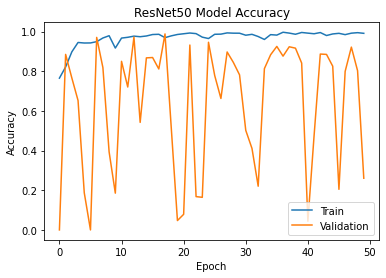

In [109]:
# plot model accuracy over epochs
plt.plot(hist_resnet.history['accuracy'])
plt.plot(hist_resnet.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

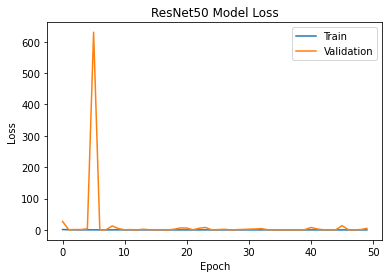

In [110]:
# Plot model loss over epochs
plt.plot(hist_resnet.history['loss'])
plt.plot(hist_resnet.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluate ResNet50

In [101]:
pred_resnet = clf_resnet.predict(X_test)

In [102]:
loss, accuracy = clf_resnet.evaluate(X_test, y_test)

40/40 [==============================] - 2s 61ms/step - loss: 1.1520 - accuracy: 0.7994 0s - loss: 0.213


In [103]:
predictions_resnet = tf.argmax(pred_resnet, axis=1) # decode back to int from one-hot representation
print(predictions_resnet)

tf.Tensor([0 0 0 ... 1 1 3], shape=(1271,), dtype=int64)


### ResNet50 model confusion matrix and classification report

In [104]:
cf_matrix_resnet = confusion_matrix(true_class, predictions_vgg16)

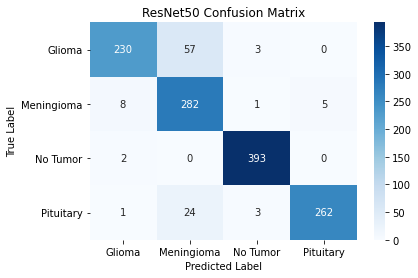

In [113]:
x_axis_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
y_axis_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

sns.heatmap(cf_matrix_resnet, annot=True,xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='', cmap='Blues')
plt.title('ResNet50 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [106]:
print(classification_report(true_class, predictions_resnet, target_names = labels))

              precision    recall  f1-score   support

      glioma       0.95      0.85      0.90       290
  meningioma       0.69      0.97      0.81       296
     notumor       0.78      0.99      0.87       395
   pituitary       1.00      0.32      0.48       290

    accuracy                           0.80      1271
   macro avg       0.85      0.78      0.76      1271
weighted avg       0.85      0.80      0.77      1271



### Visualize misclassified tumors by ResNet50

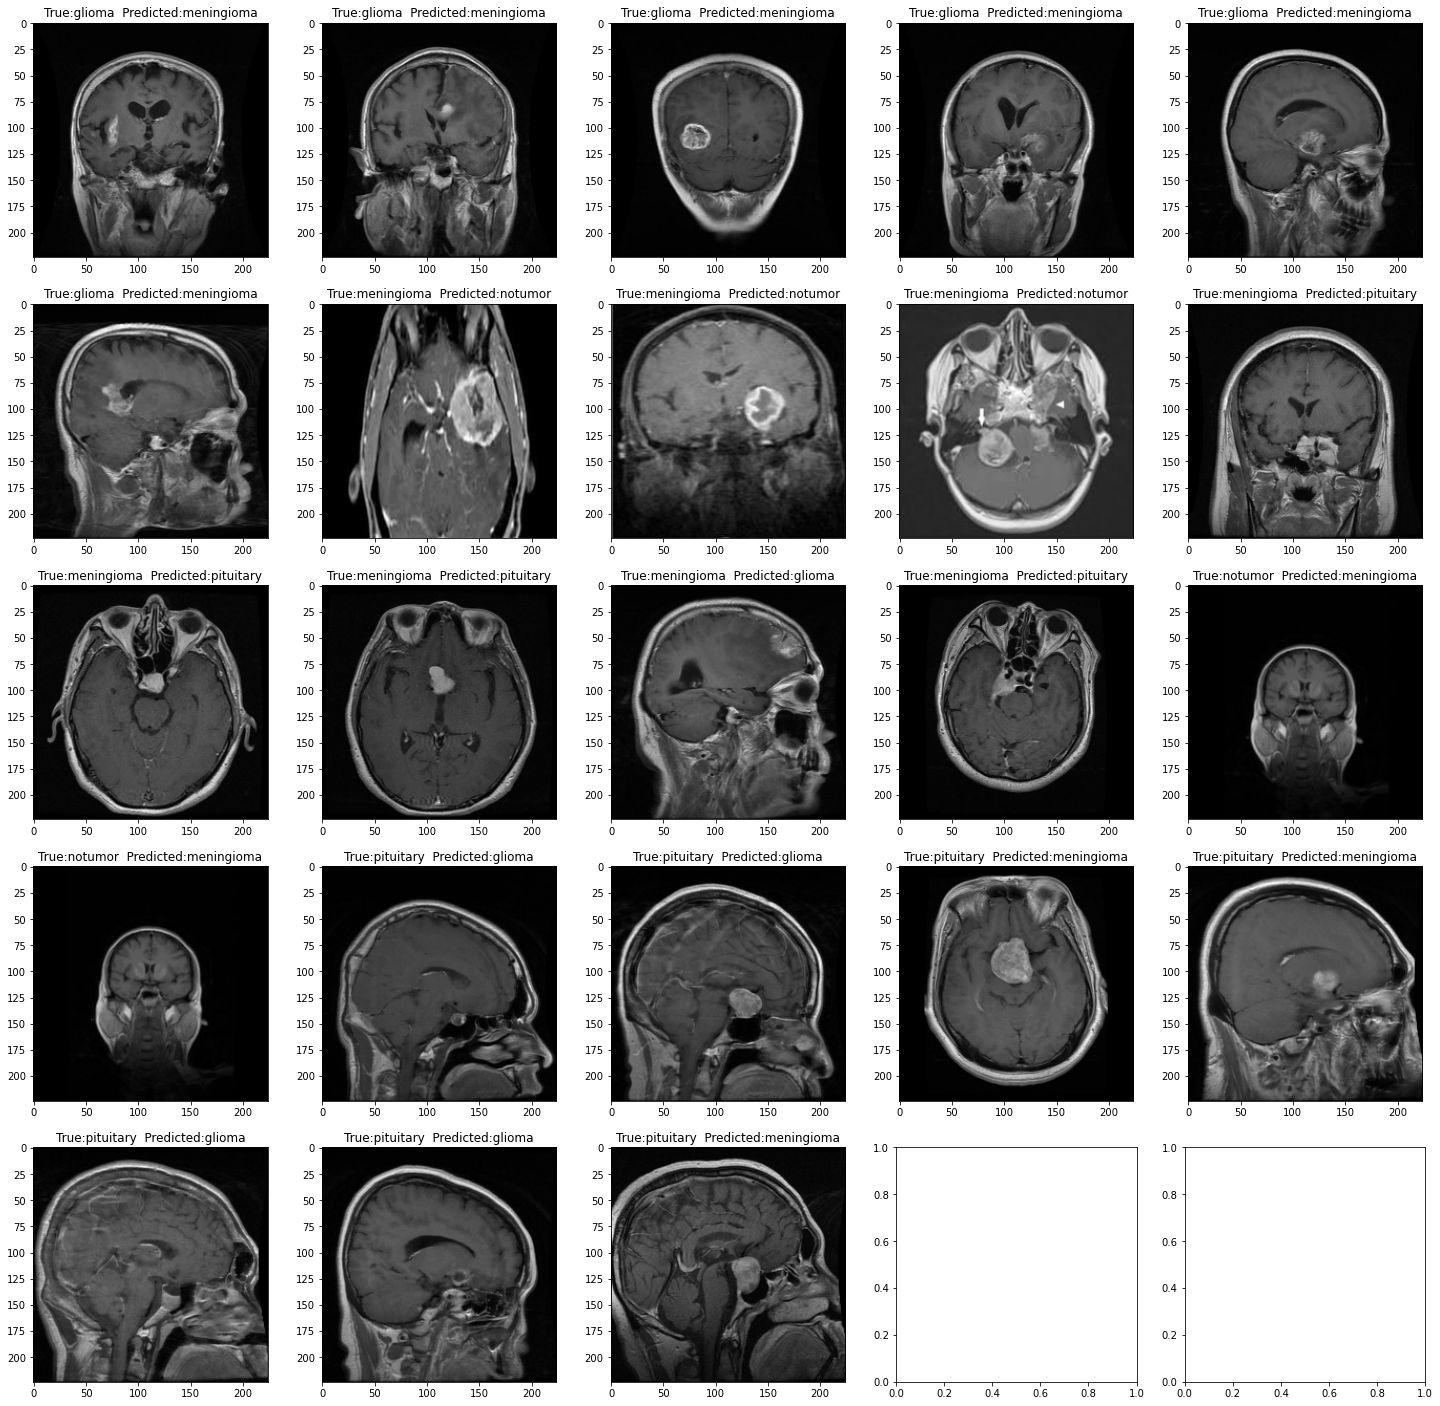

In [116]:
incorrect_resnet = np.nonzero(predictions_resnet!=true_class)[0]

def plot_images(data_index,cmap="Blues"):
    fig, ax = plt.subplots(5,5, figsize=(25,25))

    for i, index in enumerate(data_index[:25]):
        ax[i//5, i%5].imshow(X_test[index], cmap=cmap)
        ax[i//5, i%5].set_title("True:{}  Predicted:{}".format(labels[true_class[index]], labels[predictions[index]]))
    plt.show()    

plot_images(incorrect, 'gray')

In [124]:
clf_resnet.save('clf_resnet.h5')

# Predict the classes in the predict dataset using model with highest accuracy after comparing

In [117]:
predict_pred = clf.predict(predict)

In [118]:
y_pred = tf.argmax(predict_pred, axis=1) # decode back to int from one-hot representation
print(y_pred)

tf.Tensor(
[0 0 1 1 2 1 1 1 1 1 1 0 1 2 2 2 2 2 2 2 2 2 0 2 3 3 1 3 3 3 3 3 3 0 3 0 0
 0 0 0], shape=(40,), dtype=int64)


In [119]:
labels = np.array(labels)

In [120]:
print(labels[y_pred])

['glioma' 'glioma' 'meningioma' 'meningioma' 'notumor' 'meningioma'
 'meningioma' 'meningioma' 'meningioma' 'meningioma' 'meningioma' 'glioma'
 'meningioma' 'notumor' 'notumor' 'notumor' 'notumor' 'notumor' 'notumor'
 'notumor' 'notumor' 'notumor' 'glioma' 'notumor' 'pituitary' 'pituitary'
 'meningioma' 'pituitary' 'pituitary' 'pituitary' 'pituitary' 'pituitary'
 'pituitary' 'glioma' 'pituitary' 'glioma' 'glioma' 'glioma' 'glioma'
 'glioma']
